In [119]:
# essentials
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import plotly.express as px


# sklearn libraries
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_curve

# others
import warnings
import scipy.io
from google.colab import drive

# settings
warnings.filterwarnings('ignore')

In [2]:
# to fetch the dataset from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The original Mammography (Woods et al., 1993) data set was made available by the courtesy of Aleksandar Lazarevic. This dataset is publicly available in openML. It has 11,183 samples with 260 calcifications. If we look at predictive accuracy as a measure of goodness of the classifier for this case, the default accuracy would be 97.68% when every sample is labeled non-calcification. But, it is desirable for the classifier to predict most of the calcifications correctly. For outlier detection, the minority class of calcification is considered as outlier class and the non-calcification class as inliers.
[https://odds.cs.stonybrook.edu/mammography-dataset/](https://odds.cs.stonybrook.edu/mammography-dataset/)

In [7]:
# loading the dataset .mat

path = '/content/gdrive/MyDrive/Repository/Datasets/mammography/mammography.mat'

data = scipy.io.loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 18 16:51:12 2016',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.23001961,  5.0725783 , -0.27606055,  0.83244412, -0.37786573,
          0.4803223 ],
        [ 0.15549112, -0.16939038,  0.67065219, -0.85955255, -0.37786573,
         -0.94572324],
        [-0.78441482, -0.44365372,  5.6747053 , -0.85955255, -0.37786573,
         -0.94572324],
        ...,
        [ 1.2049878 ,  1.7637238 , -0.50146835,  1.5624078 ,  6.4890725 ,
          0.93129397],
        [ 0.73664398, -0.22247361, -0.05065276,  1.5096647 ,  0.53926914,
          1.3152293 ],
        [ 0.17700275, -0.19150839, -0.50146835,  1.5788636 ,  7.750705  ,
          1.5559507 ]]),
 'y': array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]], dtype=uint8)}

In [16]:
# dataframe
df = pd.DataFrame(data['X'])
df.head()


,0,1,2,3,4,5
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566


In [27]:
y = data['y'].flatten()

In [28]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

In [29]:
df['y'] = y.tolist()

In [31]:
df.tail()

,0,1,2,3,4,5,y
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,1
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,1
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,1
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,1
11182,0.177003,-0.191508,-0.501468,1.578864,7.750705,1.555951,1


In [37]:
# normal and anomaly points.
# this step is for checking the percentage of the target values.
# Iy this way, if the dataset is imbalanced, handling it is considered.

norm = df[df['y'] == 0]['y'].count()
anom = df[df['y']==1]['y'].count()
tot = len(df)
print("Percentage of normal points: {} ({}%)".format(norm, round((norm/tot)*100,2)))
print("Percentage of anomaly points: {} ({}%)".format(norm, round((anom/tot)*100,2)))

Percentage of normal points: 10923 (97.68%)
Percentage of anomaly points: 10923 (2.32%)


In [38]:
df.describe()

,0,1,2,3,4,5,y
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,11183.000000
mean,1.096536e-10,1.297595e-09,5.698113e-10,-2.435706e-09,-1.120680e-09,1.459483e-09,0.023250
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.150702
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00,0.000000
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00,1.000000


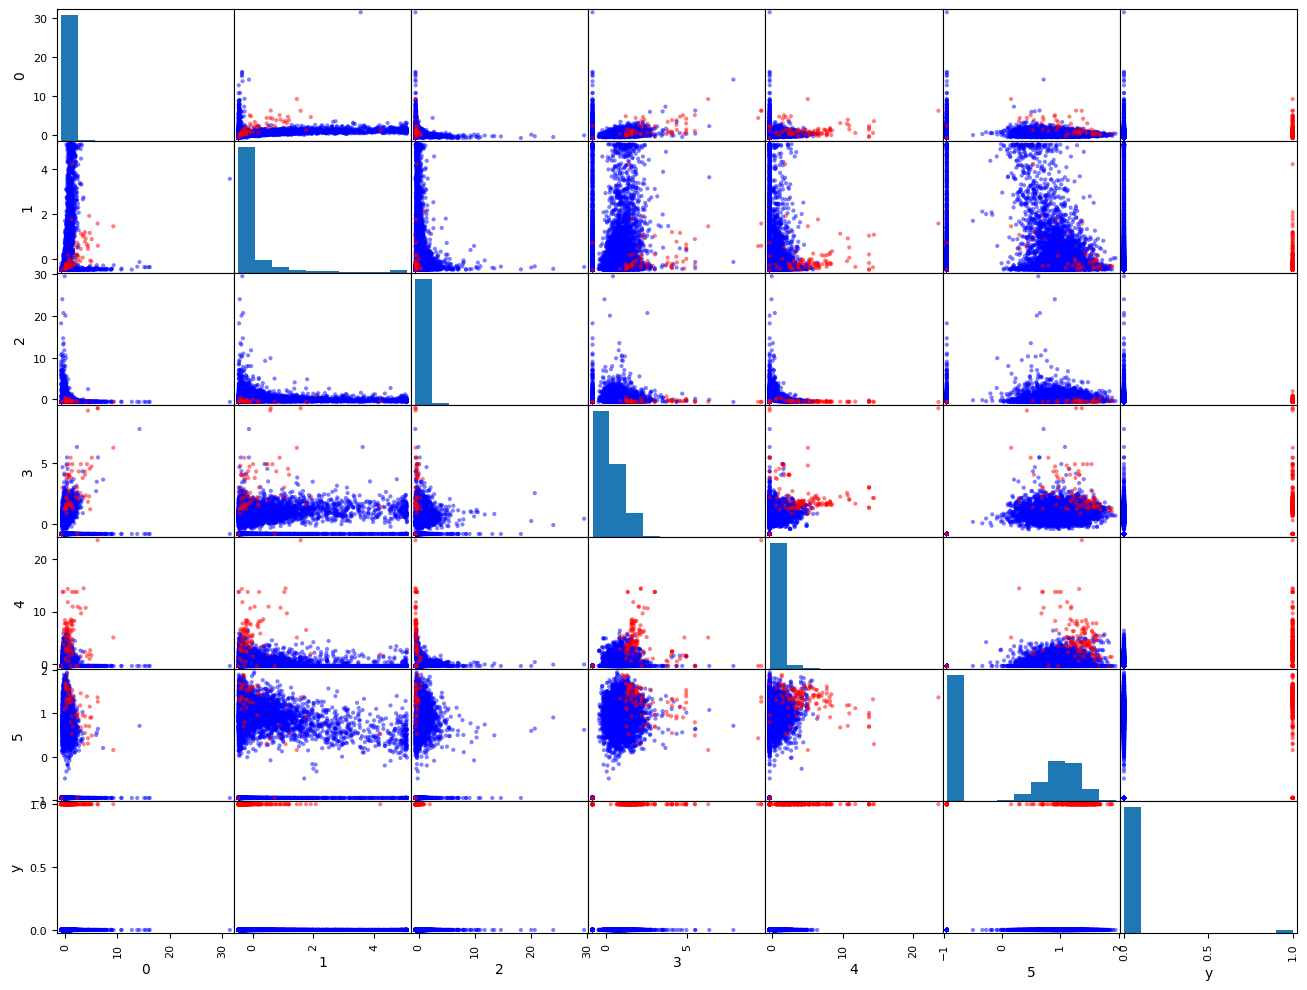

In [45]:
# this scatter plot shows the outlier point according to the target variable.
c_code = {0:'blue', 1: 'red'}

colors = df['y'].apply(lambda x: c_code[x])

pd.plotting.scatter_matrix(df, c=colors, figsize=(16,12))
plt.show()

In [75]:
# splitting the target value
X = df.drop('y', axis=1)
y = df['y']

In [82]:
# scaling

X_scaled = StandardScaler().fit_transform(X)

# PCA is not necessary. Feel free to use all the datasets.
# This is just for the visualization.
pca = PCA(n_components=2)

princ_comp = pca.fit_transform(X_scaled) # training

df_pc = pd.DataFrame(data=princ_comp, columns=['PC1','PC2']) # newly created dataframe
df_pc.head()

,PC1,PC2
0,1.948112,3.434699
1,-1.033525,0.204475
2,-0.344736,-1.986832
3,-1.072318,0.961573
4,0.853238,-0.547254


In [83]:
# Implementing the isolation forest

if_model = IsolationForest(contamination=0.02) # normal points/anomaly points
if_model.fit(df_pc)

y_hat = if_model.predict(df_pc) # predictions

In [84]:
# isolation scores and anomaly data points

df_pc['if_scores'] = if_model.decision_function(df_pc)
df_pc['if_anomalies'] = y_hat


In [85]:
df_pc.head()

,PC1,PC2,if_scores,if_anomalies
0,1.948112,3.434699,0.053117,1
1,-1.033525,0.204475,0.173641,1
2,-0.344736,-1.986832,-0.001682,-1
3,-1.072318,0.961573,0.145509,1
4,0.853238,-0.547254,0.233165,1


In [86]:
# replacing the values

df_pc['if_anomalies'] = df_pc['if_anomalies'].replace([-1, 1], ['Yes', 'No'])

In [94]:
# Visualizing the all dots

fig = px.scatter(df_pc, x='PC1', y='PC2', title = 'Normal & Anomaly Data Points')
fig.update_layout(
    font_family='Courier New',
    font_color='black',
    plot_bgcolor='white',
)

fig

In [99]:
# Visualizing the normal vs. anomalies

fig = px.scatter(df_pc, x='PC1', y='PC2',
                 title = 'Normal vs. Anomaly Points',
                 color='if_anomalies',
                 )
fig.update_layout(
    font_family='Courier New',
    font_color='black',
    plot_bgcolor='white',
)

fig

In [100]:
# Visualizing the scores

fig = px.scatter(df_pc, x='PC1', y='PC2',
                 title = 'Isolation Forest Scores',
                 color='if_scores',
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(
    font_family='Courier New',
    font_color='black',
    plot_bgcolor='white',
)

fig